In [1]:
# A 165 LINE TOPOLOGY OPTIMIZATION CODE BY NIELS AAGE AND VILLADS EGEDE JOHANSEN, JANUARY 2013
from __future__ import division
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt

In [2]:
#element stiffness matrix
def lk():
	E=1
	nu=0.3
	k=np.array([1/2-nu/6,1/8+nu/8,-1/4-nu/12,-1/8+3*nu/8,-1/4+nu/12,-1/8-nu/8,nu/6,1/8-3*nu/8])
	KE = E/(1-nu**2)*np.array([ [k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
	[k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
	[k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
	[k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
	[k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
	[k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
	[k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
	[k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]] ])
	return (KE)
# Optimality criterion
def oc(nelx,nely,x,volfrac,dc,dv,g):
	l1=0
	l2=1e9
	move=0.2
	# reshape to perform vector operations
	xnew=np.zeros(nelx*nely)
	while (l2-l1)/(l1+l2)>1e-3:
		lmid=0.5*(l2+l1)
		xnew[:]= np.maximum(0.0,np.maximum(x-move,np.minimum(1.0,np.minimum(x+move,x*np.sqrt(-dc/dv/lmid)))))
		
		gt=g+np.sum((dv*(xnew-x)))
		if gt>0 :
			l1=lmid
		else:
			l2=lmid
	return (xnew,gt)

In [100]:
# MAIN DRIVER
def main(nelx,nely,volfrac,penal,rmin,ft):
	print("Minimum compliance problem with OC")
	print("ndes: " + str(nelx) + " x " + str(nely))
	print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
	print("Filter method: " + ["Sensitivity based","Density based"][ft])
	# Max and min stiffness
	Emin=1e-9
	Emax=1.0
	# dofs:
	ndof = 2*(nelx+1)*(nely+1)
	# Allocate design variables (as array), initialize and allocate sens.
	x=volfrac * np.ones(nely*nelx,dtype=float)
	xold=x.copy()
	xPhys=x.copy()
	g=0 # must be initialized to use the NGuyen/Paulino OC approach
	dc=np.zeros((nely,nelx), dtype=float)

	# FE: Build the index vectors for the for coo matrix format.
	KE=lk()
	edofMat=np.zeros((nelx*nely,8),dtype=int)
	for elx in range(nelx):
		for ely in range(nely):
			el = ely+elx*nely
			n1=(nely+1)*elx+ely
			n2=(nely+1)*(elx+1)+ely
			edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3, 2*n2, 2*n2+1, 2*n1, 2*n1+1])

	# Construct the index pointers for the coo format
	iK = np.kron(edofMat,np.ones((8,1))).flatten()
	jK = np.kron(edofMat,np.ones((1,8))).flatten() 

	# Filter: Build (and assemble) the index+data vectors for the coo matrix format
	nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
	iH = np.zeros(nfilter)
	jH = np.zeros(nfilter)
	sH = np.zeros(nfilter)
	cc=0
	for i in range(nelx):
		for j in range(nely):
			row=i*nely+j
			kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
			kk2=int(np.minimum(i+np.ceil(rmin),nelx))
			ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
			ll2=int(np.minimum(j+np.ceil(rmin),nely))
			for k in range(kk1,kk2):
				for l in range(ll1,ll2):
					col=k*nely+l
					fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
					iH[cc]=row
					jH[cc]=col
					sH[cc]=np.maximum(0.0,fac)
					cc=cc+1

	# Finalize assembly and convert to csc format
	H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()	
	Hs=H.sum(1)
	# BC's and support
	dofs=np.arange(2*(nelx+1)*(nely+1))
	fixed=np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
	free=np.setdiff1d(dofs,fixed)
	# Solution and RHS vectors
	f=np.zeros((ndof,1))
	u=np.zeros((ndof,1))
	# Set load
	f[1,0]=-1
	# Initialize plot and plot the initial design
	plt.ion() # Ensure that redrawing is possible
	fig,ax = plt.subplots()
	im = ax.imshow(-xPhys.reshape((nelx,nely)).T, cmap='gray',\
	interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))
	fig.show()
   	# Set loop counter and gradient vectors 
	loop=0
	change=1
	dv = np.ones(nely*nelx)
	dc = np.ones(nely*nelx)
	ce = np.ones(nely*nelx)
	while change>0.01 and loop<40:
		loop=loop+1
		# Setup and solve FE problem
		sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
		K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
		# Remove constrained dofs from matrix
		K = K[free,:][:,free]
		# Solve system 
		u[free,0]=spsolve(K,f[free,0])

		# Objective and sensitivity
		ce[:] = (np.dot(u[edofMat].reshape(nelx*nely,8),KE) * u[edofMat].reshape(nelx*nely,8) ).sum(1)
		obj=( (Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
		dc[:]=(-penal*xPhys**(penal-1)*(Emax-Emin))*ce
		dv[:] = np.ones(nely*nelx)
		
		# Sensitivity filtering:
		if ft==0:
			dc[:] = np.asarray((H*(x*dc))[np.newaxis].T/Hs)[:,0] / np.maximum(0.001,x)
		elif ft==1:
			dc[:] = np.asarray(H*(dc[np.newaxis].T/Hs))[:,0]
			dv[:] = np.asarray(H*(dv[np.newaxis].T/Hs))[:,0]
		# Optimality criteria
		xold[:]=x
		(x[:],g)=oc(nelx,nely,x,volfrac,dc,dv,g)
		# Filter design variables
		if ft==0:   xPhys[:]=x
		elif ft==1:	xPhys[:]=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
		# Compute the change by the inf. norm
		change=np.linalg.norm(x.reshape(nelx*nely,1)-xold.reshape(nelx*nely,1),np.inf)
		# Plot to screen
		im.set_array(-xPhys.reshape((nelx,nely)).T)
		fig.canvas.draw()
		# Write iteration history to screen (req. Python 2.6 or newer)
		print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(\
					loop,obj,(g+volfrac*nelx*nely)/(nelx*nely),change))
	# Make sure the plot stays and that the shell remains	
	plt.show()
	# print("Press any key...")

	return -xPhys.reshape((nelx,nely)).T, u

Minimum compliance problem with OC
ndes: 180 x 60
volfrac: 0.4, rmin: 5.4, penal: 3.0
Filter method: Density based


C:\Users\kalex\AppData\Local\Temp\ipykernel_19720\165609118.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


it.: 1 , obj.: 2027.505 Vol.: 0.400, ch.: 0.200
it.: 2 , obj.: 1109.274 Vol.: 0.400, ch.: 0.200
it.: 3 , obj.: 759.678 Vol.: 0.400, ch.: 0.200
it.: 4 , obj.: 605.301 Vol.: 0.400, ch.: 0.200
it.: 5 , obj.: 551.514 Vol.: 0.400, ch.: 0.181
it.: 6 , obj.: 522.001 Vol.: 0.400, ch.: 0.200
it.: 7 , obj.: 503.316 Vol.: 0.400, ch.: 0.172
it.: 8 , obj.: 484.527 Vol.: 0.400, ch.: 0.200
it.: 9 , obj.: 466.601 Vol.: 0.400, ch.: 0.169
it.: 10 , obj.: 448.517 Vol.: 0.400, ch.: 0.193
it.: 11 , obj.: 431.318 Vol.: 0.400, ch.: 0.173
it.: 12 , obj.: 412.796 Vol.: 0.400, ch.: 0.200
it.: 13 , obj.: 393.572 Vol.: 0.400, ch.: 0.200
it.: 14 , obj.: 375.140 Vol.: 0.400, ch.: 0.200
it.: 15 , obj.: 358.937 Vol.: 0.400, ch.: 0.200
it.: 16 , obj.: 345.102 Vol.: 0.400, ch.: 0.200
it.: 17 , obj.: 334.371 Vol.: 0.400, ch.: 0.200
it.: 18 , obj.: 326.465 Vol.: 0.400, ch.: 0.200
it.: 19 , obj.: 320.638 Vol.: 0.400, ch.: 0.200
it.: 20 , obj.: 316.467 Vol.: 0.400, ch.: 0.200
it.: 21 , obj.: 313.684 Vol.: 0.400, ch.: 0.198

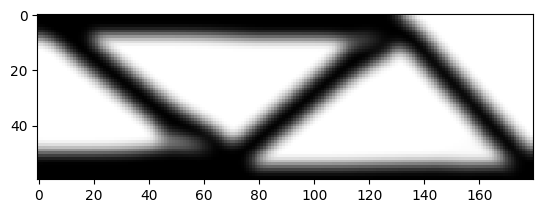

In [102]:
# Default input parameters
nelx=180
nely=60
volfrac=0.4
rmin=5.4
penal=3.0
ft=1 # ft==0 -> sens, ft==1 -> dens

xPhys_opt, u_opt = main(nelx,nely,volfrac,penal,rmin,ft)

In [103]:
import math


# Max and min stiffness
Emin=1e-9
Emax=1.0
# dofs:
ndof = 2*(nelx+1)*(nely+1)
u = u_opt
# FE: Build the index vectors for the for coo matrix format.
scale = 0.005
cell_size = 1
coords = np.zeros((ndof,1))
disp = np.zeros((ndof,1))

def gradshape(xi):
	"""Gradient of the shape functions for a 4-node, isoparametric element.
		dN_i(xi,eta)/dxi and dN_i(xi,eta)/deta
		Input: 1x2,  Output: 2x4"""
	xi,eta = tuple(xi)
	dN = [[-(1.0-eta),  (1.0-eta), (1.0+eta), -(1.0+eta)],
		  [-(1.0-xi), -(1.0+xi), (1.0+xi),  (1.0-xi)]]
	return 0.25 * np.array(dN)

# 2x2 Gauss Quadrature (4 Gauss points)
# q4 is 4x2
q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0)

###############################
# Plane-strain material tangent (see Bathe p. 194)
# C is 3x3
E = 100.0
v = 0.3
C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])

# strain in an element: [strain] = B    U
#                        3x1     = 3x8  8x1
#
# strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
#          = B11 u1          + B13 u1          + B15 u1          + B17 u1
#          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
B = np.zeros((3,8))

print('\n** Post process the data')
# (pre-allocate space for nodal stress and strain)
node_strain = []
node_stress = []
for ni in range(int(ndof/2)):
    node_strain.append([0.0, 0.0, 0.0])
    node_stress.append([0.0, 0.0, 0.0])
node_strain = np.array(node_strain)
node_stress = np.array(node_stress)

# conn element nodes indeces in node or X_coord_list ([n1, n2, n3, n4])
conn = []

# print(f'   min displacements: u1={min(u[0::2]):.4g}, u2={min(u[1::2]):.4g}')
# print(f'   max displacements: u1={max(u[0::2]):.4g}, u2={max(u[1::2]):.4g}')
emin = np.array([ 9.0e9,  9.0e9,  9.0e9])
emax = np.array([-9.0e9, -9.0e9, -9.0e9])
smin = np.array([ 9.0e9,  9.0e9,  9.0e9])
smax = np.array([-9.0e9, -9.0e9, -9.0e9])

for elx in range(nelx):
    for ely in range(nely):
        el = ely+elx*nely
        n1=(nely+1)*elx+ely
        n2=(nely+1)*(elx+1)+ely

        x_center = cell_size/2 + cell_size * elx
        y_center = - cell_size/2 - cell_size * ely

        # x coords
        coords[2*n1+2] = x_center - cell_size/2
        coords[2*n2+2] = x_center + cell_size/2
        coords[2*n2] = x_center + cell_size/2
        coords[2*n1] = x_center - cell_size/2

        # y coords
        coords[2*n1+3] = y_center - cell_size/2
        coords[2*n2+3] = y_center - cell_size/2
        coords[2*n2+1] = y_center + cell_size/2
        coords[2*n1+1] = y_center + cell_size/2

         #                           x       y       x       y    x       y       x       y
        # edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3, 2*n2, 2*n2+1, 2*n1, 2*n1+1])

        # print(y_center - cell_size/2)
        nodePts = np.array([[coords[2*n1+2], coords[2*n1+3]], [coords[2*n2+2], coords[2*n2+3]], [coords[2*n2], coords[2*n2+1]], [coords[2*n1], coords[2*n1+1]]]) # it is not necessary in this case, but is needed for regular mesh
        nodePts = np.squeeze(nodePts, axis=2)
        # print(nodePts.shape)

        #stress calculation
        for q in q4:
            dN = gradshape(q)					# 2x4
            J  = np.dot(dN, nodePts).T			# 2x2
            dN = np.dot(np.linalg.inv(J), dN)	# 2x4
            B[0,0::2] = dN[0,:]					# 3x8
            B[1,1::2] = dN[1,:]
            B[2,0::2] = dN[1,:]
            B[2,1::2] = dN[0,:]

            UU = np.zeros((8,1))				# 8x1 #!!!!!!!!!!mybe reordering is needed
            UU[4] = u[2*n1+2]   # x
            UU[5] = u[2*n1+3]   # y
            UU[6] = u[2*n2+2]   # x
            UU[7] = u[2*n2+3]   # y
            UU[0] = u[2*n2]     # x
            UU[1] = u[2*n2+1]   # y
            UU[2] = u[2*n1]     # x
            UU[3] = u[2*n1+1]   # y

            # get the strain and stress at the integration point
            strain = B @ UU		# (B is 3x8) (UU is 8x1) 		=> (strain is 3x1)
            stress = C @ strain	# (C is 3x3) (strain is 3x1) 	=> (stress is 3x1)
            emin[0] = min(emin[0], strain[0][0])
            emin[1] = min(emin[1], strain[1][0])
            emin[2] = min(emin[2], strain[2][0])
            emax[0] = max(emax[0], strain[0][0])
            emax[1] = max(emax[1], strain[1][0])
            emax[2] = max(emax[2], strain[2][0])

            node_strain[n1 + 1][:] = strain.T[0]    # !!!!!! there is also the reordering maybe is needed
            node_strain[n2 + 1][:] = strain.T[0]
            node_strain[n2][:] = strain.T[0]
            node_strain[n1][:] = strain.T[0]

            node_stress[n1 + 1][:] = stress.T[0]
            node_stress[n2 + 1][:] = stress.T[0]
            node_stress[n2][:] = stress.T[0]
            node_stress[n1][:] = stress.T[0]

            # node_stress[n1][:] = stress.T[0]
            # node_stress[n1 + 1][:] = stress.T[0]
            # node_stress[n2 + 1][:] = stress.T[0]
            # node_stress[n2][:] = stress.T[0]

            smax[0] = max(smax[0], stress[0][0])
            smax[1] = max(smax[1], stress[1][0])
            smax[2] = max(smax[2], stress[2][0])
            smin[0] = min(smin[0], stress[0][0])
            smin[1] = min(smin[1], stress[1][0])
            smin[2] = min(smin[2], stress[2][0])

        conn.append([n2, n1, n1 + 1, n2 + 1])

print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')


coords_disp = coords + u*scale

x_disp = u[::2]
y_disp = u[1::2]

X_coords = coords_disp[::2] # x - dof in odd indeces
Y_coords = coords_disp[1::2] # y - dof in even indeces

disp_module = np.sqrt(x_disp**2 + y_disp**2)
vM_stress = np.sqrt(node_stress[:, 0]**2 + node_stress[:, 1]**2 - node_stress[:, 1]*node_stress[:, 0])


** Post process the data
   min strains: e11=-2.4, e22=-3.256, e12=-3.564
   max strains: e11=1.392, e22=4.413, e12=1.496
   min stress:  s11=-323.3, s22=-437.2, s12=-137.1
   max stress:  s11=230.3, s22=581.8, s12=57.54


In [108]:
print(xPhys_opt.shape)
print(nelx)
print(xPhys_opt)

(60, 180)
180
[[-1.         -1.         -1.         ... -0.         -0.
  -0.        ]
 [-1.         -1.         -1.         ... -0.         -0.
  -0.        ]
 [-1.         -1.         -1.         ... -0.         -0.
  -0.        ]
 ...
 [-1.         -1.         -1.         ... -0.99997421 -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]
 [-1.         -1.         -1.         ... -1.         -1.
  -1.        ]]


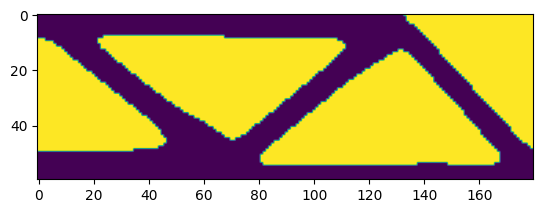

In [111]:
# plt.scatter(X_coords, Y_coords, c=vM_stress)
# plt.axis('equal')
mask = (xPhys_opt > -0.5)*1
plt.imshow(mask)
plt.show()

In [121]:
def el_mask_2_nod_mask(el_mask, nelx, nely, ndof):
    node_mask = np.zeros((int(ndof/2), 1))
    for elx in range(nelx):
        for ely in range(nely):
            if el_mask[elx, ely] == 0:
                continue
            n1=(nely+1)*elx+ely
            n2=(nely+1)*(elx+1)+ely

            node_mask[n1] = 1
            node_mask[n2] = 1
            node_mask[n1 + 1] = 1
            node_mask[n2 + 1] = 1
    
    return node_mask

el_mask = (xPhys_opt < -0.5)*1
node_mask = el_mask_2_nod_mask(el_mask.T, nelx, nely, ndof)

In [118]:
print((node_mask>0).shape)
print(X_coords.shape)

(11041, 1)
(11041, 1)


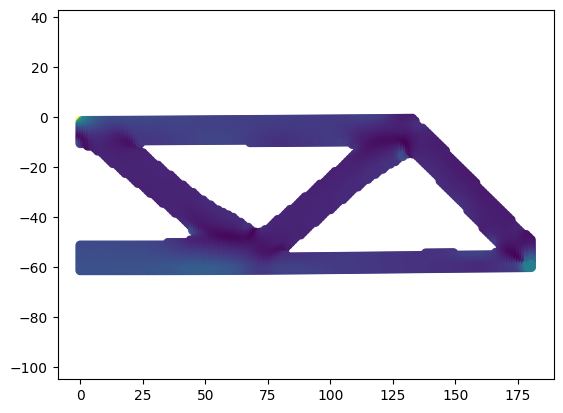

In [122]:
bool_mask = (node_mask > 0)[:, 0]

plt.scatter(X_coords[bool_mask], Y_coords[bool_mask], c=vM_stress[bool_mask])
plt.axis('equal')
plt.show()

In [16]:
# FE: Build the index vectors for the for coo matrix format.
nelx=4
nely=3

KE=lk()
edofMat=np.zeros((nelx*nely,8),dtype=int)
for elx in range(nelx):
    for ely in range(nely):
        el = ely+elx*nely   # element number   
        n1=(nely+1)*elx+ely 
        n2=(nely+1)*(elx+1)+ely
        edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3, 2*n2, 2*n2+1, 2*n1, 2*n1+1])

# Construct the index pointers for the coo format
iK = np.kron(edofMat,np.ones((8,1))).flatten()
jK = np.kron(edofMat,np.ones((1,8))).flatten() 

# Filter: Build (and assemble) the index+data vectors for the coo matrix format
nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
iH = np.zeros(nfilter)
jH = np.zeros(nfilter)
sH = np.zeros(nfilter)
cc=0
for i in range(nelx):
    for j in range(nely):
        row=i*nely+j
        kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
        kk2=int(np.minimum(i+np.ceil(rmin),nelx))
        ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
        ll2=int(np.minimum(j+np.ceil(rmin),nely))
        for k in range(kk1,kk2):
            for l in range(ll1,ll2):
                col=k*nely+l
                fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                iH[cc]=row
                jH[cc]=col
                sH[cc]=np.maximum(0.0,fac)
                cc=cc+1

In [17]:
print(nelx)
print(nely)
# print()
print(edofMat.shape)
print(edofMat)
print(edofMat[0])

4
3
(12, 8)
[[ 2  3 10 11  8  9  0  1]
 [ 4  5 12 13 10 11  2  3]
 [ 6  7 14 15 12 13  4  5]
 [10 11 18 19 16 17  8  9]
 [12 13 20 21 18 19 10 11]
 [14 15 22 23 20 21 12 13]
 [18 19 26 27 24 25 16 17]
 [20 21 28 29 26 27 18 19]
 [22 23 30 31 28 29 20 21]
 [26 27 34 35 32 33 24 25]
 [28 29 36 37 34 35 26 27]
 [30 31 38 39 36 37 28 29]]
[ 2  3 10 11  8  9  0  1]


In [94]:
# Default input parameters
nelx=30
nely=20
volfrac=0.4
rmin=5.4
penal=3.0
ft=1 # ft==0 -> sens, ft==1 -> dens

# Max and min stiffness
Emin=1e-9
Emax=1.0
# dofs:
ndof = 2*(nelx+1)*(nely+1)
# Allocate design variables (as array), initialize and allocate sens.
x=volfrac * np.ones(nely*nelx,dtype=float)
xold=x.copy()
xPhys=x.copy()
g=0 # must be initialized to use the NGuyen/Paulino OC approach
dc=np.zeros((nely,nelx), dtype=float)

# FE: Build the index vectors for the for coo matrix format.
KE=lk()
edofMat=np.zeros((nelx*nely,8),dtype=int)
for elx in range(nelx):
    for ely in range(nely):
        el = ely+elx*nely
        n1=(nely+1)*elx+ely
        n2=(nely+1)*(elx+1)+ely
        edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3, 2*n2, 2*n2+1, 2*n1, 2*n1+1])

# Construct the index pointers for the coo format
iK = np.kron(edofMat,np.ones((8,1))).flatten()
jK = np.kron(edofMat,np.ones((1,8))).flatten() 

# Filter: Build (and assemble) the index+data vectors for the coo matrix format
nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
iH = np.zeros(nfilter)
jH = np.zeros(nfilter)
sH = np.zeros(nfilter)
cc=0
for i in range(nelx):
    for j in range(nely):
        row=i*nely+j
        kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
        kk2=int(np.minimum(i+np.ceil(rmin),nelx))
        ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
        ll2=int(np.minimum(j+np.ceil(rmin),nely))
        for k in range(kk1,kk2):
            for l in range(ll1,ll2):
                col=k*nely+l
                fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
                iH[cc]=row
                jH[cc]=col
                sH[cc]=np.maximum(0.0,fac)
                cc=cc+1

# Finalize assembly and convert to csc format
H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()	
Hs=H.sum(1)
# BC's and support
dofs=np.arange(2*(nelx+1)*(nely+1))
fixed=np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
free=np.setdiff1d(dofs,fixed)
# Solution and RHS vectors
f=np.zeros((ndof,1))
u=np.zeros((ndof,1))
# Set load
f[1,0]=-1
# Initialize plot and plot the initial design
# Set loop counter and gradient vectors 
loop=0
change=1
dv = np.ones(nely*nelx)
dc = np.ones(nely*nelx)
ce = np.ones(nely*nelx)


# Setup and solve FE problem
sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
# Remove constrained dofs from matrix
K = K[free,:][:,free]
# Solve system 
u[free,0]=spsolve(K,f[free,0])    
# Objective and sensitivity
    

In [27]:
print(min(u))
print(max(u))
print(ndof)
print(u.shape)

[-743.38614264]
[243.18068107]
1722
(1722, 1)


In [95]:
import math

# FE: Build the index vectors for the for coo matrix format.
scale = 0.005
cell_size = 1
coords = np.zeros((ndof,1))
disp = np.zeros((ndof,1))

def gradshape(xi):
	"""Gradient of the shape functions for a 4-node, isoparametric element.
		dN_i(xi,eta)/dxi and dN_i(xi,eta)/deta
		Input: 1x2,  Output: 2x4"""
	xi,eta = tuple(xi)
	dN = [[-(1.0-eta),  (1.0-eta), (1.0+eta), -(1.0+eta)],
		  [-(1.0-xi), -(1.0+xi), (1.0+xi),  (1.0-xi)]]
	return 0.25 * np.array(dN)

# 2x2 Gauss Quadrature (4 Gauss points)
# q4 is 4x2
q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0)

###############################
# Plane-strain material tangent (see Bathe p. 194)
# C is 3x3
E = 100.0
v = 0.3
C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])

# strain in an element: [strain] = B    U
#                        3x1     = 3x8  8x1
#
# strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
#          = B11 u1          + B13 u1          + B15 u1          + B17 u1
#          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
B = np.zeros((3,8))

print('\n** Post process the data')
# (pre-allocate space for nodal stress and strain)
node_strain = []
node_stress = []
for ni in range(int(ndof/2)):
    node_strain.append([0.0, 0.0, 0.0])
    node_stress.append([0.0, 0.0, 0.0])
node_strain = np.array(node_strain)
node_stress = np.array(node_stress)

# conn element nodes indeces in node or X_coord_list ([n1, n2, n3, n4])
conn = []

# print(f'   min displacements: u1={min(u[0::2]):.4g}, u2={min(u[1::2]):.4g}')
# print(f'   max displacements: u1={max(u[0::2]):.4g}, u2={max(u[1::2]):.4g}')
emin = np.array([ 9.0e9,  9.0e9,  9.0e9])
emax = np.array([-9.0e9, -9.0e9, -9.0e9])
smin = np.array([ 9.0e9,  9.0e9,  9.0e9])
smax = np.array([-9.0e9, -9.0e9, -9.0e9])

for elx in range(nelx):
    for ely in range(nely):
        el = ely+elx*nely
        n1=(nely+1)*elx+ely
        n2=(nely+1)*(elx+1)+ely

        x_center = cell_size/2 + cell_size * elx
        y_center = - cell_size/2 - cell_size * ely

        # x coords
        coords[2*n1+2] = x_center - cell_size/2
        coords[2*n2+2] = x_center + cell_size/2
        coords[2*n2] = x_center + cell_size/2
        coords[2*n1] = x_center - cell_size/2

        # y coords
        coords[2*n1+3] = y_center - cell_size/2
        coords[2*n2+3] = y_center - cell_size/2
        coords[2*n2+1] = y_center + cell_size/2
        coords[2*n1+1] = y_center + cell_size/2

         #                           x       y       x       y    x       y       x       y
        # edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3, 2*n2, 2*n2+1, 2*n1, 2*n1+1])

        # print(y_center - cell_size/2)
        nodePts = np.array([[coords[2*n1+2], coords[2*n1+3]], [coords[2*n2+2], coords[2*n2+3]], [coords[2*n2], coords[2*n2+1]], [coords[2*n1], coords[2*n1+1]]]) # it is not necessary in this case, but is needed for regular mesh
        nodePts = np.squeeze(nodePts, axis=2)
        # print(nodePts.shape)

        #stress calculation
        for q in q4:
            dN = gradshape(q)					# 2x4
            J  = np.dot(dN, nodePts).T			# 2x2
            dN = np.dot(np.linalg.inv(J), dN)	# 2x4
            B[0,0::2] = dN[0,:]					# 3x8
            B[1,1::2] = dN[1,:]
            B[2,0::2] = dN[1,:]
            B[2,1::2] = dN[0,:]

            UU = np.zeros((8,1))				# 8x1 #!!!!!!!!!!mybe reordering is needed
            UU[4] = u[2*n1+2]   # x
            UU[5] = u[2*n1+3]   # y
            UU[6] = u[2*n2+2]   # x
            UU[7] = u[2*n2+3]   # y
            UU[0] = u[2*n2]     # x
            UU[1] = u[2*n2+1]   # y
            UU[2] = u[2*n1]     # x
            UU[3] = u[2*n1+1]   # y

            # get the strain and stress at the integration point
            strain = B @ UU		# (B is 3x8) (UU is 8x1) 		=> (strain is 3x1)
            stress = C @ strain	# (C is 3x3) (strain is 3x1) 	=> (stress is 3x1)
            emin[0] = min(emin[0], strain[0][0])
            emin[1] = min(emin[1], strain[1][0])
            emin[2] = min(emin[2], strain[2][0])
            emax[0] = max(emax[0], strain[0][0])
            emax[1] = max(emax[1], strain[1][0])
            emax[2] = max(emax[2], strain[2][0])

            node_strain[n1 + 1][:] = strain.T[0]    # !!!!!! there is also the reordering maybe is needed
            node_strain[n2 + 1][:] = strain.T[0]
            node_strain[n2][:] = strain.T[0]
            node_strain[n1][:] = strain.T[0]

            node_stress[n1 + 1][:] = stress.T[0]
            node_stress[n2 + 1][:] = stress.T[0]
            node_stress[n2][:] = stress.T[0]
            node_stress[n1][:] = stress.T[0]

            # node_stress[n1][:] = stress.T[0]
            # node_stress[n1 + 1][:] = stress.T[0]
            # node_stress[n2 + 1][:] = stress.T[0]
            # node_stress[n2][:] = stress.T[0]

            smax[0] = max(smax[0], stress[0][0])
            smax[1] = max(smax[1], stress[1][0])
            smax[2] = max(smax[2], stress[2][0])
            smin[0] = min(smin[0], stress[0][0])
            smin[1] = min(smin[1], stress[1][0])
            smin[2] = min(smin[2], stress[2][0])

        conn.append([n2, n1, n1 + 1, n2 + 1])

print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')


coords_disp = coords + u*scale

x_disp = u[::2]
y_disp = u[1::2]

X_coords = coords_disp[::2] # x - dof in odd indeces
Y_coords = coords_disp[1::2] # y - dof in even indeces

disp_module = np.sqrt(x_disp**2 + y_disp**2)
vM_stress = np.sqrt(node_stress[:, 0]**2 + node_stress[:, 1]**2 - node_stress[:, 1]*node_stress[:, 0])


** Post process the data
   min strains: e11=-10.63, e22=-3.222, e12=-33.63
   max strains: e11=12.01, e22=28.45, e12=7.674
   min stress:  s11=-1230, s22=-529.7, s12=-1293
   max stress:  s11=2797, s22=3557, s12=295.2


In [61]:
print(min(node_stress[:, 0]), max(node_stress[:, 0]))
print(min(node_stress[:, 1]), max(node_stress[:, 1]))
print(min(node_stress[:, 2]), max(node_stress[:, 2]))

-1661.667124803708 516.983182946758
-3556.123158384839 100.03231068803974
-243.2966749312092 1020.8796286467725


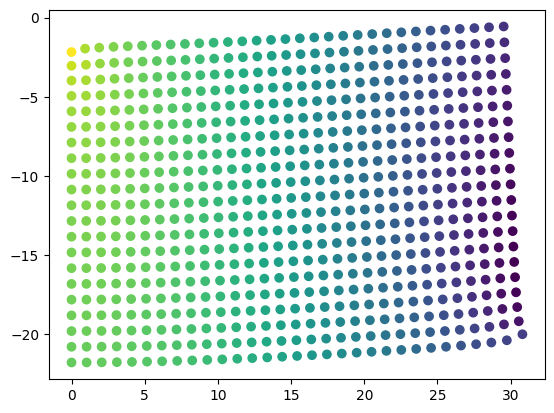

In [96]:
plt.scatter(X_coords, Y_coords, c=disp_module)
plt.show()

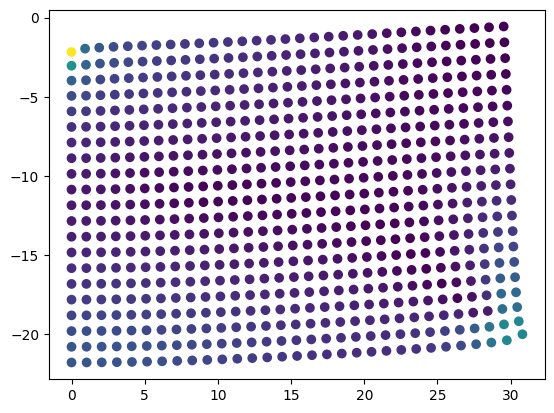

In [97]:
plt.scatter(X_coords, Y_coords, c=vM_stress)
plt.show()

In [44]:
print(disp_module.shape)
print(node_stress[:, 1, np.newaxis].shape)

(861, 1)
(861, 1)


In [28]:
# initializing list
test_list = [3, 6, 7, 8, 9, 2, 1, 5]
 
# printing original list
print("The original list : " + str(test_list))
 
# Using list slicing
# Separating odd and even index elements
print(test_list[::2])
print(test_list[1::2])

The original list : [3, 6, 7, 8, 9, 2, 1, 5]
[3, 7, 9, 1]
[6, 8, 2, 5]


In [ ]:
# for Ekaterina

# MAIN DRIVER
def main(nelx,nely,volfrac,penal,rmin,ft):
	print("Minimum compliance problem with OC")
	print("ndes: " + str(nelx) + " x " + str(nely))
	print("volfrac: " + str(volfrac) + ", rmin: " + str(rmin) + ", penal: " + str(penal))
	print("Filter method: " + ["Sensitivity based","Density based"][ft])
	# Max and min stiffness
	Emin=1e-9
	Emax=1.0
	# dofs:
	ndof = 2*(nelx+1)*(nely+1)
	# Allocate design variables (as array), initialize and allocate sens.
	x=volfrac * np.ones(nely*nelx,dtype=float)
	xold=x.copy()
	xPhys=x.copy()
	g=0 # must be initialized to use the NGuyen/Paulino OC approach
	dc=np.zeros((nely,nelx), dtype=float)

	# FE: Build the index vectors for the for coo matrix format.
	KE=lk()
	edofMat=np.zeros((nelx*nely,8),dtype=int)
	for elx in range(nelx):
		for ely in range(nely):
			el = ely+elx*nely
			n1=(nely+1)*elx+ely
			n2=(nely+1)*(elx+1)+ely
			edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3, 2*n2, 2*n2+1, 2*n1, 2*n1+1])

	# Construct the index pointers for the coo format
	iK = np.kron(edofMat,np.ones((8,1))).flatten()
	jK = np.kron(edofMat,np.ones((1,8))).flatten() 

	# Filter: Build (and assemble) the index+data vectors for the coo matrix format
	nfilter=int(nelx*nely*((2*(np.ceil(rmin)-1)+1)**2))
	iH = np.zeros(nfilter)
	jH = np.zeros(nfilter)
	sH = np.zeros(nfilter)
	cc=0
	for i in range(nelx):
		for j in range(nely):
			row=i*nely+j
			kk1=int(np.maximum(i-(np.ceil(rmin)-1),0))
			kk2=int(np.minimum(i+np.ceil(rmin),nelx))
			ll1=int(np.maximum(j-(np.ceil(rmin)-1),0))
			ll2=int(np.minimum(j+np.ceil(rmin),nely))
			for k in range(kk1,kk2):
				for l in range(ll1,ll2):
					col=k*nely+l
					fac=rmin-np.sqrt(((i-k)*(i-k)+(j-l)*(j-l)))
					iH[cc]=row
					jH[cc]=col
					sH[cc]=np.maximum(0.0,fac)
					cc=cc+1

	# Finalize assembly and convert to csc format
	H=coo_matrix((sH,(iH,jH)),shape=(nelx*nely,nelx*nely)).tocsc()	
	Hs=H.sum(1)
	# BC's and support
	dofs=np.arange(2*(nelx+1)*(nely+1))
	fixed=np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
	free=np.setdiff1d(dofs,fixed)
	# Solution and RHS vectors
	f=np.zeros((ndof,1))
	u=np.zeros((ndof,1))
	# Set load
	f[1,0]=-1
	# Initialize plot and plot the initial design
	plt.ion() # Ensure that redrawing is possible
	fig,ax = plt.subplots()
	im = ax.imshow(-xPhys.reshape((nelx,nely)).T, cmap='gray',\
	interpolation='none',norm=colors.Normalize(vmin=-1,vmax=0))
	fig.show()
   	# Set loop counter and gradient vectors 
	loop=0
	change=1
	dv = np.ones(nely*nelx)
	dc = np.ones(nely*nelx)
	ce = np.ones(nely*nelx)
	while change>0.01 and loop<40:
		loop=loop+1
		# Setup and solve FE problem
		sK=((KE.flatten()[np.newaxis]).T*(Emin+(xPhys)**penal*(Emax-Emin))).flatten(order='F')
		K = coo_matrix((sK,(iK,jK)),shape=(ndof,ndof)).tocsc()
		# Remove constrained dofs from matrix
		K = K[free,:][:,free]
		# Solve system 
		u[free,0]=spsolve(K,f[free,0])    
		# Objective and sensitivity
		ce[:] = (np.dot(u[edofMat].reshape(nelx*nely,8),KE) * u[edofMat].reshape(nelx*nely,8) ).sum(1)
		obj=( (Emin+xPhys**penal*(Emax-Emin))*ce ).sum()
		dc[:]=(-penal*xPhys**(penal-1)*(Emax-Emin))*ce
		dv[:] = np.ones(nely*nelx)
		# Sensitivity filtering:
		if ft==0:
			dc[:] = np.asarray((H*(x*dc))[np.newaxis].T/Hs)[:,0] / np.maximum(0.001,x)
		elif ft==1:
			dc[:] = np.asarray(H*(dc[np.newaxis].T/Hs))[:,0]
			dv[:] = np.asarray(H*(dv[np.newaxis].T/Hs))[:,0]
		# Optimality criteria
		xold[:]=x
		(x[:],g)=oc(nelx,nely,x,volfrac,dc,dv,g)
		# Filter design variables
		if ft==0:   xPhys[:]=x
		elif ft==1:	xPhys[:]=np.asarray(H*x[np.newaxis].T/Hs)[:,0]
		# Compute the change by the inf. norm
		change=np.linalg.norm(x.reshape(nelx*nely,1)-xold.reshape(nelx*nely,1),np.inf)
		# Plot to screen
		im.set_array(-xPhys.reshape((nelx,nely)).T)
		fig.canvas.draw()
		# Write iteration history to screen (req. Python 2.6 or newer)
		print("it.: {0} , obj.: {1:.3f} Vol.: {2:.3f}, ch.: {3:.3f}".format(\
					loop,obj,(g+volfrac*nelx*nely)/(nelx*nely),change))
	# Make sure the plot stays and that the shell remains	
	plt.show()
	# print("Press any key...")

	return -xPhys.reshape((nelx,nely)).T, u


# Default input parameters
nelx=180
nely=60
volfrac=0.4
rmin=5.4
penal=3.0
ft=1 # ft==0 -> sens, ft==1 -> dens

xPhys_opt, u_opt = main(nelx,nely,volfrac,penal,rmin,ft)

In [ ]:
# for Ekaterina
import math


# Max and min stiffness
Emin=1e-9
Emax=1.0
# dofs:
ndof = 2*(nelx+1)*(nely+1)
u = u_opt
# FE: Build the index vectors for the for coo matrix format.
scale = 0.005
cell_size = 1
coords = np.zeros((ndof,1))
disp = np.zeros((ndof,1))

def gradshape(xi):
	"""Gradient of the shape functions for a 4-node, isoparametric element.
		dN_i(xi,eta)/dxi and dN_i(xi,eta)/deta
		Input: 1x2,  Output: 2x4"""
	xi,eta = tuple(xi)
	dN = [[-(1.0-eta),  (1.0-eta), (1.0+eta), -(1.0+eta)],
		  [-(1.0-xi), -(1.0+xi), (1.0+xi),  (1.0-xi)]]
	return 0.25 * np.array(dN)

# 2x2 Gauss Quadrature (4 Gauss points)
# q4 is 4x2
q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0)

###############################
# Plane-strain material tangent (see Bathe p. 194)
# C is 3x3
E = 100.0
v = 0.3
C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])

# strain in an element: [strain] = B    U
#                        3x1     = 3x8  8x1
#
# strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
#          = B11 u1          + B13 u1          + B15 u1          + B17 u1
#          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
B = np.zeros((3,8))

print('\n** Post process the data')
# (pre-allocate space for nodal stress and strain)
node_strain = []
node_stress = []
for ni in range(int(ndof/2)):
    node_strain.append([0.0, 0.0, 0.0])
    node_stress.append([0.0, 0.0, 0.0])
node_strain = np.array(node_strain)
node_stress = np.array(node_stress)

# conn element nodes indeces in node or X_coord_list ([n1, n2, n3, n4])
conn = []

# print(f'   min displacements: u1={min(u[0::2]):.4g}, u2={min(u[1::2]):.4g}')
# print(f'   max displacements: u1={max(u[0::2]):.4g}, u2={max(u[1::2]):.4g}')
emin = np.array([ 9.0e9,  9.0e9,  9.0e9])
emax = np.array([-9.0e9, -9.0e9, -9.0e9])
smin = np.array([ 9.0e9,  9.0e9,  9.0e9])
smax = np.array([-9.0e9, -9.0e9, -9.0e9])

for elx in range(nelx):
    for ely in range(nely):
        el = ely+elx*nely
        n1=(nely+1)*elx+ely
        n2=(nely+1)*(elx+1)+ely

        x_center = cell_size/2 + cell_size * elx
        y_center = - cell_size/2 - cell_size * ely

        # x coords
        coords[2*n1+2] = x_center - cell_size/2
        coords[2*n2+2] = x_center + cell_size/2
        coords[2*n2] = x_center + cell_size/2
        coords[2*n1] = x_center - cell_size/2

        # y coords
        coords[2*n1+3] = y_center - cell_size/2
        coords[2*n2+3] = y_center - cell_size/2
        coords[2*n2+1] = y_center + cell_size/2
        coords[2*n1+1] = y_center + cell_size/2

         #                           x       y       x       y    x       y       x       y
        # edofMat[el,:]=np.array([2*n1+2, 2*n1+3, 2*n2+2, 2*n2+3, 2*n2, 2*n2+1, 2*n1, 2*n1+1])

        # print(y_center - cell_size/2)
        nodePts = np.array([[coords[2*n1+2], coords[2*n1+3]], [coords[2*n2+2], coords[2*n2+3]], [coords[2*n2], coords[2*n2+1]], [coords[2*n1], coords[2*n1+1]]]) # it is not necessary in this case, but is needed for regular mesh
        nodePts = np.squeeze(nodePts, axis=2)
        # print(nodePts.shape)

        #stress calculation
        for q in q4:
            dN = gradshape(q)					# 2x4
            J  = np.dot(dN, nodePts).T			# 2x2
            dN = np.dot(np.linalg.inv(J), dN)	# 2x4
            B[0,0::2] = dN[0,:]					# 3x8
            B[1,1::2] = dN[1,:]
            B[2,0::2] = dN[1,:]
            B[2,1::2] = dN[0,:]

            UU = np.zeros((8,1))				# 8x1 #!!!!!!!!!!mybe reordering is needed
            UU[4] = u[2*n1+2]   # x
            UU[5] = u[2*n1+3]   # y
            UU[6] = u[2*n2+2]   # x
            UU[7] = u[2*n2+3]   # y
            UU[0] = u[2*n2]     # x
            UU[1] = u[2*n2+1]   # y
            UU[2] = u[2*n1]     # x
            UU[3] = u[2*n1+1]   # y

            # get the strain and stress at the integration point
            strain = B @ UU		# (B is 3x8) (UU is 8x1) 		=> (strain is 3x1)
            stress = C @ strain	# (C is 3x3) (strain is 3x1) 	=> (stress is 3x1)
            emin[0] = min(emin[0], strain[0][0])
            emin[1] = min(emin[1], strain[1][0])
            emin[2] = min(emin[2], strain[2][0])
            emax[0] = max(emax[0], strain[0][0])
            emax[1] = max(emax[1], strain[1][0])
            emax[2] = max(emax[2], strain[2][0])

            node_strain[n1 + 1][:] = strain.T[0]    # !!!!!! there is also the reordering maybe is needed
            node_strain[n2 + 1][:] = strain.T[0]
            node_strain[n2][:] = strain.T[0]
            node_strain[n1][:] = strain.T[0]

            node_stress[n1 + 1][:] = stress.T[0]
            node_stress[n2 + 1][:] = stress.T[0]
            node_stress[n2][:] = stress.T[0]
            node_stress[n1][:] = stress.T[0]

            # node_stress[n1][:] = stress.T[0]
            # node_stress[n1 + 1][:] = stress.T[0]
            # node_stress[n2 + 1][:] = stress.T[0]
            # node_stress[n2][:] = stress.T[0]

            smax[0] = max(smax[0], stress[0][0])
            smax[1] = max(smax[1], stress[1][0])
            smax[2] = max(smax[2], stress[2][0])
            smin[0] = min(smin[0], stress[0][0])
            smin[1] = min(smin[1], stress[1][0])
            smin[2] = min(smin[2], stress[2][0])

        conn.append([n2, n1, n1 + 1, n2 + 1])

print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')


coords_disp = coords + u*scale

x_disp = u[::2]
y_disp = u[1::2]

X_coords = coords_disp[::2] # x - dof in odd indeces
Y_coords = coords_disp[1::2] # y - dof in even indeces

disp_module = np.sqrt(x_disp**2 + y_disp**2)
vM_stress = np.sqrt(node_stress[:, 0]**2 + node_stress[:, 1]**2 - node_stress[:, 1]*node_stress[:, 0])

In [ ]:
# for Ekaterina
def el_mask_2_nod_mask(el_mask, nelx, nely, ndof):
    node_mask = np.zeros((int(ndof/2), 1))
    for elx in range(nelx):
        for ely in range(nely):
            if el_mask[elx, ely] == 0:
                continue
            n1=(nely+1)*elx+ely
            n2=(nely+1)*(elx+1)+ely

            node_mask[n1] = 1
            node_mask[n2] = 1
            node_mask[n1 + 1] = 1
            node_mask[n2 + 1] = 1
    
    return node_mask

el_mask = (xPhys_opt < -0.5)*1
node_mask = el_mask_2_nod_mask(el_mask.T, nelx, nely, ndof)

In [ ]:
# for Ekaterina
bool_mask = (node_mask > 0)[:, 0]

plt.scatter(X_coords[bool_mask], Y_coords[bool_mask], c=vM_stress[bool_mask])
plt.axis('equal')
plt.show()